# Opening a new restaurant
### In this notebook the data science toolkit will be used to determine what kind of restaurant to open and the best location for that restaurant.

### The problem:

Jeff represents a firm who is looking to open a new restaurant in Portland, OR. Portland is known for its food scene and Jeff's firm wants a piece of the action. However, Jeff isn't sure what about the tastes of Portlander's or what works, he also doesn't know much about the neighborhoods.

### Analytic Approach:

The objective is to use data to determine the preferences of people in Portland, OR and also use data to determine what a good area of Portland would be to open a new restaurant.

### Data Requirements:

The required data for this analysis consists of:

Geospatial data for Portland, OR. [Portlandmaps.com](www.portlandmaps.com)

General Data by Neighborhood. This data would be things like neighborhood population, median income, walkability etc.
This was accomplished by scraping this website:
[Portland Neighborhoods by the numbers](https://www.pdxmonthly.com/home-and-real-estate/2019/03/portland-neighborhoods-by-the-numbers-2019-the-city)

Data on expected growth. We want to incorporate possible future residents in the analysis to get ahead of the demand.
This was accomplished by downloading data on all residential building permits from [Portlandmaps.com](www.portlandmaps.com)

Data on restaurants and other locations that may attract possible customers.
This was accomplished using the [Foursquare](www.foursquare.com) api.

### Methodology:
After acquiring the data, some general exploratory analysis was conducted to get a good feel for what the different communities looked like.  

The demographic data, the expected growth data, and the foursquare data were combined to determine the best type of food and location for a new restaurant.



In [1]:
#import libraries
#import standard libraries
from collections import defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#for plots
import matplotlib.pyplot as plt
import seaborn as sns

#import html/scraping libraries
import requests
from bs4 import BeautifulSoup
import json
from pandas.io.json import json_normalize

#import mapping libraries
import geopy
import folium
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from IPython.display import Image

#import colors
import matplotlib.cm as cm
import matplotlib.colors as colors
import branca.colormap

#### Load local data

In [2]:
#Uncomment to dl
'''#download portland geojson
!wget -q -O 'pdx_data.geojson' https://opendata.arcgis.com/datasets/9f50a605cf4945259b983fa35c993fe9_125.geojson'''

"#download portland geojson\n!wget -q -O 'pdx_data.geojson' https://opendata.arcgis.com/datasets/9f50a605cf4945259b983fa35c993fe9_125.geojson"

In [3]:
with open('pdx_data.geojson') as f:
    pdx_geo = json.load(f)

In [6]:
permits_df = pd.read_csv('Residential_Building_Permits.csv')
#lets look at the time frame of the permits
print('Date Range : {} to {}'.format(min(permits_df['YEAR_']),max(permits_df['YEAR_'])))
print('Size of the data: {}'.format(permits_df.shape))

#narrow the results to 2016 and after
permits_df = permits_df[permits_df['YEAR_'] >= 2016] #restrict range
permits_df = permits_df[permits_df['NEWCLASS'].isin(['New Construction','Addition'])]#restrict activity
permits_df = permits_df[permits_df['NBRHOOD'].notnull()] #clear missing data
print('After 2016 and cleaning: {}'.format(permits_df.shape))


Date Range : 1994 to 2019
Size of the data: (30106, 28)
After 2016 and cleaning: (4663, 28)


#### Scrape demographic data

In [8]:
pdxdata_url = 'https://www.pdxmonthly.com/home-and-real-estate/2019/03/portland-neighborhoods-by-the-numbers-2019-the-city'
pdx_soup = BeautifulSoup(requests.get(pdxdata_url).text,'lxml')
#get a list of columns
col_names = [i.text for i in pdx_soup.find_all('th')]
#extraxt each datapoint for each row in the table
by_hood = [[entry.text for entry in row.find_all('td')]for row in pdx_soup.find_all('tr')[1:]]
pdx_hood_df = pd.DataFrame(columns=col_names, data=by_hood)
print('Data Size: {}'.format(pdx_hood_df.shape))
pdx_hood_df.head(3)

Data Size: (96, 57)


Neighborhood Average home sale price ($)  \
0                  ALAMEDA                     785,713   
1              ARBOR LODGE                     465,743   
2  ARDENWALD-JOHNSON CREEK                     418,640   

  Median home sale price ($) Average cost per square foot ($)  \
0                    738,000                              268   
1                    459,450                              252   
2                    434,500                              185   

  Days on market (avg.) Homes sold in 2018 (#) Condo sales (%)  \
0                    31                     81              0%   
1                    28                    132             13%   
2                    89                     10              0%   

  1-year median price change (2017–2018) (%)  \
0                                         8%   
1                                         1%   
2                                        -7%   

  5-year median price change (2014–2018) (%) Distressed property sales (%)  \
0                                        26%                            1%   
1                                        33%                            0%   
2                                        34%                           10%   

  Average year built for sold homes Adjusted population  \
0                              1932               5,641   
1                              1957               7,245   
2                              1941               2,015   

  Adjusted population density (people per square mile, excluding parks and industrial tracts)  \
0                                              9,544                                            
1                                              8,654                                            
2                                             10,273                                            

  Median age Median household income ($) Home ownership (%)  \
0         41                     109,616               78.6   
1         36                      75,223               68.2   
2         41                      95,630               55.4   

  Married (except separated) (%) Divorced (%) Widowed (%) Separated (%)  \
0                           55.8         10.4         3.2           0.9   
1                           47.1         10.2         2.7           1.5   
2                           42.9         15.5         6.9           0.9   

  Never Married (%)  \
0              29.7   
1              38.3   
2              33.7   

  Population with bachelor degree as highest level of education (25 and older) (%)  \
0                                                 40                                 
1                                               33.5                                 
2                                               20.4                                 

  Population with graduate degree (25 and older) (%)  \
0                                               33.9   
1                                               18.8   
2                                                 13   

  Renters - median monthly housing expenses ($)  \
0                                         1,897   
1                                         1,456   
2                                         1,699   

  People below federal poverty level (%) Unemployed (16 years and older) (%)  \
0                                    6.6                                 3.7   
1                                    9.8                                   5   
2                                   10.6                                 2.2   

  English as only language (%)  \
0                         92.8   
1                           86   
2                         89.8   

  Percent of households with children under 18 years (%)  \
0                                               36.3       
1                                               29.8       
2                                               29.6       

  

In [9]:
#general cleaning (drop total for portland)
pdx_hood_df.drop(pdx_hood_df.index[95], inplace=True)

#### Get geocoords for each neighborhood and add it to portland hood df.

In [13]:
geolocator = Nominatim(user_agent="extra_lime")
#Before we continue, lets get the geocoords for each neighborhood (you may need to run a few times)
lats = []
longs = []
for i in range(len(pdx_hood_df['Neighborhood'])):
    location = None
    while location == None:
        if i%5==0: #print every 5 to verify activity
            print(pdx_hood_df['Neighborhood'][i])
        address = "{}, PORTLAND, OREGON".format(pdx_hood_df['Neighborhood'][i])         
        location = geolocator.geocode(address, timeout=None)
        lats.append(location.latitude)
        longs.append(location.longitude)
pdx_hood_df['Latitude'] = lats
pdx_hood_df['Longitude'] = longs

ALAMEDA


/home/extralime/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `timeout=None` has been passed to a geocoder call. Using default geocoder timeout. In geopy 2.0 the behavior will be different: None will mean "no timeout" instead of "default geocoder timeout". Pass geopy.geocoders.base.DEFAULT_SENTINEL instead of None to get rid of this warning.
  # This is added back by InteractiveShellApp.init_path()


ARNOLD CREEK
BRIDGETON
CENTENNIAL
CULLY
ELIOT
GOOSE HOLLOW
HEALY HEIGHTS
HOSFORD-ABERNETHY
KING
MADISON SOUTH
MONTAVILLA
NORTHWEST DISTRICT
PARKROSE HEIGHTS
POWELLHURST-GILBERT
RUSSELL
SOUTH TABOR
SUNDERLAND
WEST PORTLAND PARK


In [14]:
#check the nieghborhood number in each df
print("the geo file contains {} neighborhoods \nthe permit file contains {} neighborhoods \nthe neighborhood df contains {} neighborhoods".format(len(pdx_geo['features']),len(permits_df.NBRHOOD.unique()),len(pdx_hood_df['Neighborhood'])))

the geo file contains 98 neighborhoods 
the permit file contains 105 neighborhoods 
the neighborhood df contains 95 neighborhoods


In [15]:
geo_hoods = [pdx_geo['features'][i]['properties']['MAPLABEL'].lower() for i in range(len(pdx_geo['features']))]
permit_hoods = [i.lower() for i in permits_df.NBRHOOD.unique()]
n_hoods = [i.lower() for i in pdx_hood_df['Neighborhood']]

In [16]:
before = [i for i in n_hoods if i not in geo_hoods]
after = ['argay terrace','brentwood-darlington','brooklyn action corps','buckman community association',
         'centennial community association','cully association of neighbors','portland downtown',
         'dunthorpe','goose hollow foothills league','hayden island neighborhood network',
         'hosford-abernethy neighborhood district assn.','irvington community association',
         'lloyd district community association','mt. scott-arleta','mt. tabor','northwest district association',
         'old town community association','parkrose heights association of neighbors','pearl district',
         'sabin community association','sellwood-moreland improvement league','southwest hills residential league',
         'sumner association of neighbors','sunderland association of neighbors', 'wilkes community group']
replace_d = {k:v for k,v, in zip(before,after)}

In [17]:
#the replace dictionary looks good lets update the names
old_names = [i.lower() for i in pdx_hood_df['Neighborhood']]
new_names = [replace_d[i].upper() if i in replace_d.keys() else i.upper() for i in old_names]
#set neighborhood column back in df
pdx_hood_df['Neighborhood'] = new_names
#Drop Dunthorpe (not enough data)
pdx_hood_df = pdx_hood_df[pdx_hood_df["Neighborhood"]!= 'DUNTHORPE']
#uncomment to save to df
#pdx_hood_df.to_csv('pdx_hoods.csv',index=False)

In [18]:
#Continue cleaning on permits some permits are issued in overlapping neighborhood
#keep the first neighborhood and extend the truncation
comb_list = [i.split('/')[0] if '/' in i else i for i in permits_df.NBRHOOD ]
permits_df['NBRHOOD'] = comb_list
p_replace = {'CENTENNIAL COMMUNITY ASSN.':'CENTENNIAL COMMUNITY ASSOCIATION'}
old_names = [i for i in permits_df.NBRHOOD]
new_names = [p_replace[i].upper() if i in p_replace.keys() else i.upper() for i in old_names]
permits_df['NBRHOOD'] = new_names

### Visualize some of the data

#### Permits by year, neighborhood (map)

In [20]:
#add legend by basic map
legend_html = '''
                <div style="color:white;
                            background:black;
                            position: fixed; 
                            bottom: 50px; left: 50px; width: 100px; height: 180px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend <br>
                              &nbsp; 2016 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                              &nbsp; 2017 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                              &nbsp; 2018 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:orange"></i><br>                          
                              &nbsp; 2019 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:yellow"></i>
                </div>
                ''' 

In [21]:
#get geocoords for portland
address = "Portland, OR"

geolocator = Nominatim(user_agent="extra_lime")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Portland, OR are {}, {}.'.format(latitude, longitude))

#Look at a map of permits issued
#look at a map with the neighborhoods
# create map of Toronto using latitude and longitude values from geocoder
permit_map = folium.Map(location=[latitude, longitude], zoom_start=12)
colors = ['blue','green','orange','yellow']
years = list(permits_df['YEAR_'].unique())
# add markers to map
for i in range(len(years)):
    temp_df = permits_df[permits_df['YEAR_']==years[i]][['Y','X','NBRHOOD']]
    for lat, lng, neighborhood in zip(temp_df['Y'], temp_df['X'], temp_df['NBRHOOD']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color=colors[i],
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.5,
            parse_html=False).add_to(permit_map)  
    
permit_map.get_root().html.add_child(folium.Element(legend_html))
permit_map 

The geograpical coordinate of Portland, OR are 45.5202471, -122.6741949.


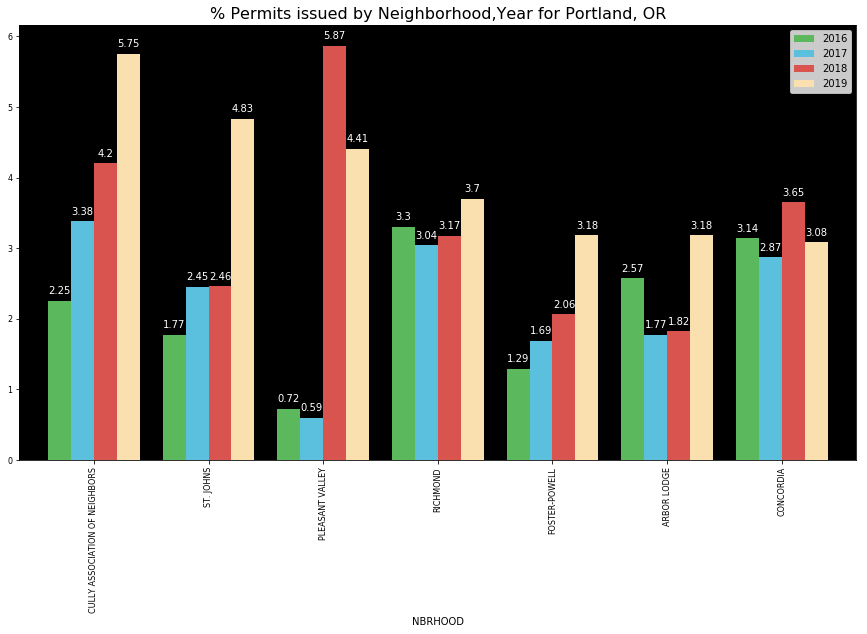

In [23]:
#Lets reshape the data to see the permits by year for each neighborhood
viz_df = permits_df.groupby(['NBRHOOD','YEAR_']).size().unstack().reset_index()
viz_df.replace(np.nan,0,inplace=True)
viz_df.set_index('NBRHOOD',inplace=True)
viz_df.sort_values(by=2019,ascending=False,inplace=True)
#lets turn these into percentages for better visuals
for col in viz_df:
    viz_df[col] = round((viz_df[col]/viz_df[col].sum())*100,2)
    
#since the df is sorted by 2019 volume of permits, we can graph the top 7 neighborhoods based on 2019 levels
p_chart = viz_df.head(7).plot(kind='bar',
                               figsize=(15,8),
                               width=.8,
                               color=['#5cb85c', '#5bc0de', '#d9534f','#FAE0AE'],
                               fontsize=8)

plt.title('% Permits issued by Neighborhood,Year for Portland, OR',fontsize=16)
p_chart.legend(fontsize=10)
p_chart.patch.set_facecolor('black')



for p in p_chart.patches:
    p_chart.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=10,
                color='white'
               )
plt.show()


In [24]:
# More cleaning
geo_missing = list(set([i.upper() for i in geo_hoods]).difference(set(pdx_hood_df['Neighborhood'])))
#we update the geo_json file, we need to find out the place of the unknown neighborhoods
missing_idx = {}
for i in geo_missing:
    for j in range(len(pdx_geo['features'])):        
        if pdx_geo['features'][j]['properties']['NAME'] == i:
            missing_idx[i] = j
missing_idx

{'MC UNCLAIMED #14': 53,
 'MC UNCLAIMED #11': 44,
 'MC UNCLAIMED #5': 17,
 'MC UNCLAIMED #13': 49}

In [25]:
#we want to remove unclaimed 14, 5, 13 and rename 11
#we pop in order of descending idx so as to not change the position
print('Length before {}'.format(len(pdx_geo['features'])))
pdx_geo['features'].pop(53)
pdx_geo['features'].pop(49)
pdx_geo['features'].pop(44)
pdx_geo['features'].pop(17)
print('Length after {}'.format(len(pdx_geo['features'])))

Length before 98
Length after 94


In [26]:
#Lets get the stat from the permits df that we want and add it to the hood_df
p_grouped =permits_df.groupby('NBRHOOD')['NEW_UNITS'].sum().reset_index()
p_grouped.columns=['Neighborhood', 'New Units']
new_units = []
for i in pdx_hood_df['Neighborhood']:
    if i in list(p_grouped['Neighborhood']):
        new_units.append(int(p_grouped[p_grouped['Neighborhood']==i]['New Units']))
    else:
        new_units.append(0)
pdx_hood_df['New Units'] = new_units

### Use chloropleth maps to examine populations by neighborhood

In [27]:
pdx_hood_df['Adjusted population'] = [int(i.replace(',','')) for i in pdx_hood_df['Adjusted population']]
pdx_map = folium.Map(location=[latitude, longitude], zoom_start=11)
pdx_map.choropleth(
    geo_data=pdx_geo,
    data=pdx_hood_df,
    columns=['Neighborhood', 'Adjusted population'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population in Portland, Oregon',
    reset=True
)
pdx_map

/home/extralime/.local/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [28]:
pdx_hood_df['Adjusted population density (people per square mile, excluding parks and industrial tracts)']\
= [int(i.replace(',','')) for i in pdx_hood_df['Adjusted population density (people per square mile, excluding parks and industrial tracts)']]

In [29]:
pdx_map = folium.Map(location=[latitude, longitude], zoom_start=11)
pdx_map.choropleth(
    geo_data=pdx_geo,
    data=pdx_hood_df,
    columns=['Neighborhood', 'Adjusted population density (people per square mile, excluding parks and industrial tracts)'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Density in Portland, Oregon',
    reset=True
)
pdx_map

In [30]:
#first lets create a dataframe with basic information about each neighborhood
pdx_df = pdx_hood_df[['Neighborhood','Adjusted population','Median age', 'Latitude','Longitude',
 'Median household income ($)','Walk score','New Units','5-year median price change (2014–2018) (%)',
'Adjusted population density (people per square mile, excluding parks and industrial tracts)']].copy()
#lets adjust the names of the columns
pdx_df.columns = ['Neighborhood',
 'Adjusted population',
 'Median age',
 'Latitude',
 'Longitude',
 'Median household income ',
 'Walk score',
 'New Units',
 '5-year median price change',
 'Adjusted population density ']
#convert data to mathable types
pdx_df['5-year median price change'][85] = 0
for col in pdx_df.iloc[:,1:]:
    pdx_df[col] = pdx_df[col].astype(str)
    pdx_df[col] = [float(i.replace(',','').replace('%','')) for i in pdx_df[col]]

/home/extralime/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Use data from the permits data with the demogrpahic data to get an idea of expected growth

In [31]:
#Now we will incorporate the the new units, an assumption of 1.5 persons increase per new unit is given.
sq_miles = pd.Series(pdx_df['Adjusted population']/pdx_df['Adjusted population density '])
new_pop = pd.Series(pdx_df['Adjusted population']+ (pdx_df['New Units']*1.5))
pdx_df['new_density']=new_pop/sq_miles
pdx_df['pop_d_change'] = pdx_df['new_density']-pdx_df['Adjusted population density ']

In [33]:
#lets look at the map again and plot the change
pdx_map = folium.Map(location=[latitude, longitude], zoom_start=12)
pdx_map.choropleth(
    geo_data=pdx_geo,
    data=pdx_df,
    columns=['Neighborhood', 'pop_d_change'],
    key_on='feature.properties.NAME',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Expected Population Density Change Portland, Oregon',
    reset=True
)
pdx_map

By now we have a general sense of the population and new construction in Portland. One main take aways at this point. The city center is a location with high population and high population density. However, when the permits data is incorporated, it is also apparent that a lot of new development is taking place.

Now we need to some venue data from foursquare to see what kind of restaurants work in Portland.

## Using the foursquare API

The foursquare API was used for a two different things.

1. Restaurant data based on Neighborhood
    + a function was written to take the center of the neighborhood, retrieve a list of restaurants. Then move north by approximately 1 mile, collect those restaurants, move east,south and west. This delivered a robust list of restaurants within 'walking distance' from the neighborhood centroid
2. Collect a list of alternate venues that would impact foot traffic.
    + while the list is not exhaustive, it certainly produces a more accurate view of how 'busy' the area is.  The categories are 'arts','hotels','universities','highschools','nightlife spots', and 'office'.
    + each category was given a weight to increase or decrease impact on expected food traffic. ie a wieght of 100 for hotels vs 50 for offices.
    + restaurants in the same category were heavily negatively weighted, and restaurants in general were weighted negatively

In [34]:
#this cell retrieves id and key info for the foursquare api
#you need your own keys as this json is not included in the repo
with open('foursquare.json') as f:
    fs = f.read()
creds = json.loads(fs)
CLIENT_ID = creds['CLIENT_ID']
CLIENT_SECRET = creds['CLIENT_SECRET']
VERSION = creds["VERSION"]

In [35]:
#Borrow function from foursquare lab
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Function to retireve 5 points per neighborhood

In [36]:
#function to get a more robust list of food venues around a centroid
def get_5(name,start_lat,start_long,radius,category,limit):
    #adds a buffer to lat and long
    loc_lats = [start_lat,start_lat,start_lat,start_lat+.01,start_lat-.01]
    loc_longs = [start_long,start_long+.01,start_long-.01,start_long,start_long]
    v5_dfs=[]
    #iterate for each buffer
    for i in range(5):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        loc_lats[i], 
        loc_longs[i], 
        radius,
        category,
        limit)
        venues = None
        #keep trying if response is corrupted
        while venues == None:
            
            results = requests.get(url).json()
        
            try:
                venues = results['response']['groups'][0]['items']
            except: 'KeyError'

            nearby_venues = json_normalize(venues) # flatten JSON
            #get unique ids for each venue
            ids = [venues[i]['venue']['id'] if venues[i]['venue']['id'] \
                   else None for i in range(len(venues))]
            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues =nearby_venues.loc[:, filtered_columns]
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
            nearby_venues['id'] = ids

            v5_dfs.append(nearby_venues)
    #combine dfs
    all_df = pd.concat(v5_dfs)
    #drop duplucates by unique id
    all_df = all_df.drop_duplicates(subset='id')
    n_l = (str(name+',')*all_df.shape[0]).split(',')[:-1]
    n_lat = ((str(start_lat)+',')*all_df.shape[0]).split(',')[:-1]
    n_long = ((str(start_long)+',')*all_df.shape[0]).split(',')[:-1]

    all_df['Neighborhood'] = n_l
    all_df['Neighborhood Lat'] = n_lat
    all_df['Neighborhood Long'] = n_long
    
    return all_df

### Function to get counts of venues to be weighted

In [37]:
def get_weight_counts(names,lats,longs,category,cat_names,radius, limit):
    counts = pd.DataFrame()
    counts['Neighborhood'] = names
    for cat, cat_name in zip(category,cat_names):
        count = []
        for lat,long in zip(lats,longs):
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat, 
            long, 
            radius,
            cat,
            limit)
            
            results = requests.get(url).json()
            if results['response']['totalResults']:
                cnts = results['response']['totalResults']
                count.append(cnts)
            else:
                count.append(0)
        counts[cat_name] = count
    
    return counts

### Function to iterate by neighborhood and combine all results into 1 DataFrame

this function may need to be ran more than once, it will print the current neighborhood, therefor if the service times out and you receive a "NoneType" error, find the index of the neighborhood and use .iloc[idx:] to resume. Create separate DFs for each run, then use pd.concat to combine them. You can see the 'raw' notebook to see this.

In [38]:
#function to get a list of food venues around a list of centroids
def get_hood_venues(name,lat,long,radius,category,limit):
    n_dfs = []
    for name,lat,long in zip(name,lat,long):
        print(name)
        n_dfs.append(get_5(name=name,start_lat=lat,start_long=long,radius=radius,category=category,limit=limit))
    
    all_df = pd.concat(n_dfs)
    return all_df

### Example use of functions

#### Get weights

In [39]:
#we need to exclude forest park as a neighbohood because it is a park
no_fp = pdx_df[pdx_df['Neighborhood'] != 'FOREST PARK']

In [40]:
#weights df
categories = ['4d4b7104d754a06370d81259','4bf58dd8d48988d1fa931735',
             '4bf58dd8d48988d1ae941735','4bf58dd8d48988d13d941735',
              '4d4b7105d754a06376d81259','4bf58dd8d48988d124941735']
cat_names = ['arts','hotels',
             'university','highschool',
             'nightlife','office']
weights_df = get_weight_counts(names=no_fp['Neighborhood'],
                            lats=no_fp['Latitude'],
                            longs=no_fp['Longitude'],
                            radius=1500,
                            category=categories,
                            cat_names=cat_names,
                            limit=1000)

In [42]:
#Now we have counts of venues that may attract additional customers throughout the day,
#we assign values to each to denote the level of contribution
mult = {'arts':25,
       'hotels':100,
       'university':100,
       'highschool':50,
       'nightlife':75,
       'office':50}
#multiple each by their contribution
for col in weights_df.iloc[:,1:]:
    weights_df[col] = weights_df[col]*mult[col]
weights_df.head()

Neighborhood  arts  hotels  university  highschool  nightlife  \
0                  ALAMEDA   275     200           0         200       1800   
1              ARBOR LODGE   100     500           0         100       2550   
2  ARDENWALD-JOHNSON CREEK   225       0           0           0        600   
3            ARGAY TERRACE   100     200         100         150        300   
4        ARLINGTON HEIGHTS   575     200           0           0       1725   

   office  
0     900  
1     750  
2     700  
3     750  
4    1200

In [43]:
weights_df.to_csv('weights_df.csv',index=False)

### Get restaurants


In [41]:
#Uncomment to run the function and save csv
"""#run the fuction to get an extended list food venues in portland neighborhoods
pdx_food = get_hood_venues(name=no_fp.iloc[0:]['Neighborhood'],
                            lat=no_fp.iloc[0:]['Latitude'],
                            long=no_fp.iloc[0:]['Longitude'],
                            radius=1500,
                            category='4d4b7105d754a06374d81259',
                            limit=1000)
pdx_food.to_csv('pdx_food.csv',index=False)  """                          

"#run the fuction to get an extended list food venues in portland neighborhoods\npdx_food = get_hood_venues(name=no_fp.iloc[0:]['Neighborhood'],\n                            lat=no_fp.iloc[0:]['Latitude'],\n                            long=no_fp.iloc[0:]['Longitude'],\n                            radius=1500,\n                            category='4d4b7105d754a06374d81259',\n                            limit=1000)\npdx_food.to_csv('pdx_food.csv',index=False)  "

In [44]:
#load in food csv
pdx_food = pd.read_csv('pdx_food.csv')

In [45]:
pdx_food.head()

name                       categories        lat  \
0                Lucca               Italian Restaurant  45.548167   
1           Mojo Sushi                 Sushi Restaurant  45.548351   
2           Kargi Gogo              Dumpling Restaurant  45.559113   
3  Pine State Biscuits  Southern / Soul Food Restaurant  45.558981   
4             Urdaneta                 Tapas Restaurant  45.559136   

          lng                        id Neighborhood  Neighborhood Lat  \
0 -122.641375  4a8cb082f964a520e60e20e3      ALAMEDA         45.548631   
1 -122.650162  4cd0b8fb6200b1f71925d628      ALAMEDA         45.548631   
2 -122.634038  5b1b270795d986002ce0fee5      ALAMEDA         45.548631   
3 -122.642697  4c38a007dfb0e21efbdeaea8      ALAMEDA         45.548631   
4 -122.634119  5786bc45498e6ad53328f935      ALAMEDA         45.548631   

   Neighborhood Long  
0        -122.636481  
1        -122.636481  
2        -122.636481  
3        -122.636481  
4        -122.636481

In [46]:
#we drop food trucks because they dont have a category and the hours arent standard
pdx_food = pdx_food[pdx_food['categories']!= 'Food Truck']

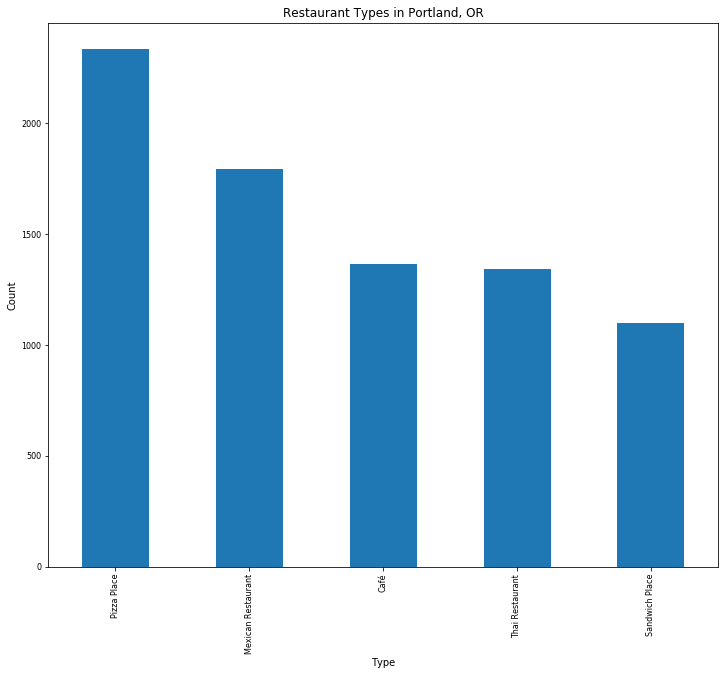

In [84]:
#We can get an overall view of the most popular types of food in portland.
g = pdx_food.groupby('categories').count().sort_values(by='name',ascending=False).head().reset_index()[['categories','name']]\
.plot(kind='bar',
      x='categories',
      y='name',
      figsize=(12,10),
      fontsize=8,
     legend=False)
plt.title('Restaurant Types in Portland, OR')
plt.xlabel('Type')
plt.ylabel('Count')
plt.savefig('rest.png')

It seems that Pizza, Mexican Food and cafes are the most numerous. Lets look at a Neighborhood level analysis

In [51]:
#Lets analyze each neighborhood
# one hot encoding
pdx_onehot = pd.get_dummies(pdx_food[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pdx_onehot['Neighborhood'] = pdx_food['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [pdx_onehot.columns[-1]] + list(pdx_onehot.columns[:-1])
pdx_onehot = pdx_onehot[fixed_columns]
#group by neighborhood and get mean frequency of each category
pdx_grouped = pdx_onehot.groupby('Neighborhood').mean().reset_index()

#function to sort in order of most popular

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
#create dataframe for top 10 venues in each neighborhood
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = pdx_grouped['Neighborhood']

for ind in np.arange(pdx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pdx_grouped.iloc[ind, :], num_top_venues)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head(20)

(93, 6)


Neighborhood 1st Most Common Venue  \
0                            ALAMEDA           Pizza Place   
1                        ARBOR LODGE           Pizza Place   
2            ARDENWALD-JOHNSON CREEK           Pizza Place   
3                      ARGAY TERRACE  Fast Food Restaurant   
4                  ARLINGTON HEIGHTS           Pizza Place   
5                       ARNOLD CREEK           Pizza Place   
6                           ASHCREEK           Pizza Place   
7                  BEAUMONT-WILSHIRE           Pizza Place   
8                              BOISE           Pizza Place   
9               BRENTWOOD-DARLINGTON           Pizza Place   
10                         BRIDGETON  Fast Food Restaurant   
11                        BRIDLEMILE           Pizza Place   
12             BROOKLYN ACTION CORPS           Pizza Place   
13     BUCKMAN COMMUNITY ASSOCIATION    Mexican Restaurant   
14                    CATHEDRAL PARK           Pizza Place   
15  CENTENNIAL COMMUNITY ASSOCIATION           Pizza Place   
16                      COLLINS VIEW    Mexican Restaurant   
17                         CONCORDIA           Pizza Place   
18                CRESTON-KENILWORTH           Pizza Place   
19                         CRESTWOOD  Fast Food Restaurant   

   2nd Most Common Venue 3rd Most Common Venue          4th Most Common Venue  \
0                   Café       Thai Restaurant             Mexican Restaurant   
1     Mexican Restaurant       Thai Restaurant                           Café   
2                   Café   American Restaurant                Thai Restaurant   
3     Mexican Restaurant        Sandwich Place                           Food   
4                   Café       Thai Restaurant                 Sandwich Place   
5   Fast Food Restaurant    Mexican Restaurant                 Sandwich Place   
6     Mexican Restaurant                  Café       Mediterranean Restaurant   
7                   Café       Thai Restaurant             Mexican Restaurant   
8                   Café    Mexican Restaurant                 Sandwich Place   
9     Mexican Restaurant    Chinese Restaurant            American Restaurant   
10   American Restaurant        Sandwich Place             Seafood Restaurant   
11    Mexican Restaurant                  Food                     Restaurant   
12    Mexican Restaurant                  Café             Italian Restaurant   
13       Thai Restaurant        Sandwich Place                    Pizza Place   
14    Mexican Restaurant                  Food                     Restaurant   
15    Mexican Restaurant    Chinese Restaurant           Fast Food Restaurant   
16           Pizza Place        Sandwich Place           Fast Food Restaurant   
17    Mexican Restaurant                  Café             Italian Restaurant   
18    Mexican Restaurant       Thai Restaurant  Vegetarian / Vegan Restaurant   
19    Mexican Restaurant           Pizza Place       Mediterranean Restaurant   

   5th Most Common Venue  
0                 Bakery  
1     Chinese Restaurant  
2                 Bakery  
3            Pizza Place  
4    American Restaurant  
5         Breakfast Spot  
6   Fast Food Restaurant  
7             Restaurant  
8        Thai Restaurant  
9                 Bakery  
10        Breakfast Spot  
11                  Café  
12   American Restaurant  
13        Breakfast Spot  
14         Deli / Bodega  
15                 Diner  
16                Bakery  
17        Breakfast Spot  
18        Breakfast Spot  
19        Sandwich Place

At this point, it is decided that no matter which neighborhood is chosen, Pizza or Mexican should work. Since Jeff is new to the area, he wants something that he knows will work.

In [52]:
#lets narrow this DF down to pizza places and mexican food
mexican_pizza = pdx_food[pdx_food['categories'].isin(['Pizza Place','Mexican Restaurant'])]
others = pdx_food[pdx_food['categories']!='Pizza Place']
others = pdx_food[pdx_food['categories']!='Mexican Restaurant']

In [53]:
#now lets count pizza places and mexican restaurants
#Lets analyze each neighborhood
# one hot encoding
p_mx_onehot = pd.get_dummies(mexican_pizza[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
p_mx_onehot['Neighborhood'] = mexican_pizza['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [p_mx_onehot.columns[-1]] + list(p_mx_onehot.columns[:-1])
p_mx_onehot = p_mx_onehot[fixed_columns]

In [54]:
pz_mx_cnts = p_mx_onehot.groupby('Neighborhood').sum().reset_index()
#we have missing neighborhoods
hoods = [i for i in pz_mx_cnts['Neighborhood']]+["LINNTON","PLEASANT VALLEY"]
mxs = [i for i in pz_mx_cnts['Mexican Restaurant']]+[0,0]
pzs = [i for i in pz_mx_cnts['Pizza Place']]+[0,0]
new_cnts = pd.DataFrame(columns=['Neighborhood','MX','PZ'])
new_cnts['Neighborhood'] = hoods
new_cnts['MX'] = mxs
new_cnts['PZ'] = pzs

In [55]:
new_cnts.sort_values(by='Neighborhood',inplace=True)
new_cnts.reset_index(inplace=True,drop=True)
new_cnts.head()

Neighborhood  MX  PZ
0                  ALAMEDA  24  36
1              ARBOR LODGE  16  20
2  ARDENWALD-JOHNSON CREEK   8  14
3            ARGAY TERRACE  10   8
4        ARLINGTON HEIGHTS  16  20

In [61]:
#drop forest park, as we did not compile foursquare data.
pdx_df = pdx_df[pdx_df['Neighborhood']!= 'FOREST PARK'].reset_index(drop=True).sort_values(by='Neighborhood')
# sort the weights df
weights_df= weights_df.sort_values(by='Neighborhood').reset_index(drop=True)

In [62]:
weights_df.head()

Neighborhood  arts  hotels  university  highschool  nightlife  \
0                  ALAMEDA   275     200           0         200       1800   
1              ARBOR LODGE   100     500           0         100       2550   
2  ARDENWALD-JOHNSON CREEK   225       0           0           0        600   
3            ARGAY TERRACE   100     200         100         150        300   
4        ARLINGTON HEIGHTS   575     200           0           0       1725   

   office  
0     900  
1     750  
2     700  
3     750  
4    1200

In [63]:
#add column of additional contributions (sum row)
pdx_df['add'] = weights_df.sum(axis=1)
pdx_df['subtract'] = new_cnts.sum(axis=1)*-50 #negative weight for pizza or mexican
#lesser negative weight for other restaurants
pdx_df['others'] = others.groupby('Neighborhood').count().reset_index()['name']*-25 

In [65]:
#general cleanup
pdx_df.drop(['index','level_0'],1,inplace=True)
pdx_df.head()

Neighborhood  Adjusted population  Median age   Latitude  \
0                  ALAMEDA               5641.0        41.0  45.548631   
1              ARBOR LODGE               7245.0        36.0  45.571794   
2  ARDENWALD-JOHNSON CREEK               2015.0        41.0  45.458516   
3            ARGAY TERRACE               6035.0        40.0  45.552830   
4        ARLINGTON HEIGHTS               1804.0        52.0  45.519496   

    Longitude  Median household income   Walk score  New Units  \
0 -122.636481                  109616.0        65.0       30.0   
1 -122.690152                   75223.0        72.0      443.0   
2 -122.627539                   95630.0        54.0       10.0   
3 -122.523204                   51990.0        45.0       58.0   
4 -122.710667                  113665.0        40.0        1.0   

   5-year median price change  Adjusted population density    new_density  \
0                        26.0                        9544.0   9620.135437   
1                        33.0                        8654.0   9447.731263   
2                        34.0                       10273.0  10349.473945   
3                        52.0                        6942.0   7042.075228   
4                         9.0                        8934.0   8941.428492   

   pop_d_change   add  subtract  others  
0     76.135437  3375     -3000   -8650  
1    793.731263  4000     -1800   -3650  
2     76.473945  1525     -1100   -3200  
3    100.075228  1600      -900   -2050  
4      7.428492  3700     -1800   -7250

### Creating a 'score' for each neighborhood

At this point we know that Jeff with either open a mexican restaurant or a pizza place. Now it must be determined which neighborhood would be best. We want to incorporate factors like population, expected growth, median household income, walkability, contributing factors and detracting factors.  The following formulat will be used:

$((Adjusted Population +New Units) * .75) * Median House Hold Income)) + Contributions - (Same Restaurants + other restaurants) * Walk Score / 1000000000$

 + ((Adjusted Population +New Units) * .75) * Median House Hold Income)):
     - This portion takes the current poplatuin level, adds the expected population growth (we assumed 1.5 people per new unit) and multiplies by .75. We multiply by .75 to try to capture the fact that it is not every person in the neighborhood that has the median income.
 + +Contributions
     - This is the impact that was determined by venues that in theory would attract foot traffic
 + - (Same Restaurant + other restaurants)
     - This is negative impact of having similar restaurants in the area and having restaurants in general in the area
 + * Walk Score
     - This captures the walkability of the neighborhood
 + / 1000000000
     - An arbitrary to divisor to reduce the number to two decimals

In [66]:
pdx_df['total_score'] = ((((pdx_df["Adjusted population"]+pdx_df['New Units'])*.75)*pdx_df['Median household income '])+pdx_df['add']+pdx_df['subtract']+pdx_df['others'])*pdx_df['Walk score']/1000000000

In [67]:
pdx_df.sort_values(by='total_score',ascending=False)[['Neighborhood','total_score']].head()

Neighborhood  total_score
57  NORTHWEST DISTRICT ASSOCIATION    95.551915
70                        RICHMOND    68.000171
17                       CONCORDIA    54.394694
31                       HAZELWOOD    53.850306
52                      MONTAVILLA    50.044402

### Results

By a long shot, NORTHWEST DISTRICT ASSOCIATION is the best neighborhood to open a pizza place or a mexican restaurant.
We can check visually to see if this makes sense

In [68]:
nw = pdx_df[pdx_df['Neighborhood'] == 'NORTHWEST DISTRICT ASSOCIATION']
nw_permits = permits_df[permits_df['NBRHOOD']=='NORTHWEST DISTRICT ASSOCIATION']
nw_pz_mx = mexican_pizza[mexican_pizza['Neighborhood']=='NORTHWEST DISTRICT ASSOCIATION']
nw_legend_html = '''
                <div style="color:white;
                            background:black;
                            position: fixed; 
                            bottom: 50px; left: 50px; width: 180px; height: 100px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend <br>
                              &nbsp; Mexican or Pizza &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br>
                              &nbsp; New Construction &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>

                </div>
                ''' 


In [70]:
nw_lat = nw['Latitude']
nw_long = nw['Longitude']
nw_map = folium.Map(location=[nw_lat, nw_long], zoom_start=15)
steps=200
colormap = branca.colormap.linear.YlGn_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(nw_map) #add color bar at the top of the map

nw_data = HeatMap(nw_permits[['Y','X','NEW_UNITS']],gradient=gradient_map)
nw_data.add_to(nw_map)
# add markers to map

for lat, lng, new_units in zip(nw_permits['Y'], nw_permits['X'], nw_permits['NEW_UNITS']):
    label = '{}'.format(new_units)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='lime',
        fill_opacity=0.5,
        parse_html=False).add_to(nw_map) 



food_cs = ['black','white']
foods = ['Mexican Restaurant','Pizza Place']
for i in range(2):
    temp_df = nw_pz_mx[nw_pz_mx['categories']==foods[i]][['lat','lng','name']]
    for lat, lng, name in zip(temp_df['lat'], temp_df['lng'], temp_df['name']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=8,
            popup=label,
            color=food_cs[i],
            fill=True,
            fill_color='red',
            fill_opacity=0.5,
            parse_html=False).add_to(nw_map) 
    
nw_map.get_root().html.add_child(folium.Element(nw_legend_html))
nw_map     

## Conclusion

The map would appear to confirm that the Northwest Neighborhood is a great candidate for a pizza place or a mexican restaurant. Particularly in the green circle in the map below

In [85]:
nw_lat = nw['Latitude']
nw_long = nw['Longitude']
nw_map1 = folium.Map(location=[45.532778, -122.691814], zoom_start=15)
folium.CircleMarker(
        [45.532778, -122.691814],
        radius=150,
        popup="In there",
        color='green',
        fill=True,
        fill_color='lime',
        fill_opacity=0.3,
        parse_html=False).add_to(nw_map1) 
for i in range(2):
    temp_df = nw_pz_mx[nw_pz_mx['categories']==foods[i]][['lat','lng','name']]
    for lat, lng, name in zip(temp_df['lat'], temp_df['lng'], temp_df['name']):
        label = '{}'.format(name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=8,
            popup=label,
            color=food_cs[i],
            fill=True,
            fill_color='red',
            fill_opacity=0.5,
            parse_html=False).add_to(nw_map1) 
nw_lat = nw['Latitude']
nw_long = nw['Longitude']
nw_map = folium.Map(location=[nw_lat, nw_long], zoom_start=15)
steps=200
colormap = branca.colormap.linear.YlGn_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(nw_map) #add color bar at the top of the map

nw_data = HeatMap(nw_permits[['Y','X','NEW_UNITS']],gradient=gradient_map)
nw_data.add_to(nw_map)
# add markers to map

for lat, lng, new_units in zip(nw_permits['Y'], nw_permits['X'], nw_permits['NEW_UNITS']):
    label = '{}'.format(new_units)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='lime',
        fill_opacity=0.5,
        parse_html=False).add_to(nw_map1) 
steps=200
colormap = branca.colormap.linear.YlGn_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(nw_map) #add color bar at the top of the map

nw_data = HeatMap(nw_permits[['Y','X','NEW_UNITS']],gradient=gradient_map)
nw_data.add_to(nw_map1)
nw_map1.get_root().html.add_child(folium.Element(nw_legend_html))
nw_map1